###   Name: Anthony Ayebiahwe
###   Title :  Visualizing Abandoned Vehicles in Philadelphia
###    Data Wrangling Final Project
 
     

In [ ]:
#Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import geopandas as gpd
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
%matplotlib inline

In [14]:
# read crime data downloaded from Open Philly
df=pd.read_csv('C:/Users/Anthony Ayebiahwe/Desktop/public_cases_fc.csv')

In [15]:
# Finding the length of the data row and checking the head for the columns
print("the number rows in df=",len(df))


the number rows in df= 1048575


In [16]:
df.head()

the_geom        lon  objectid  \
0  0101000020E6100000EC66674D43CF52C036779195A1FB... -75.238483         2   
1  0101000020E61000009946B4991ACE52C0D77734C4E7F9... -75.220374         3   
2  0101000020E61000004967A200F8CD52C0685BAC2CFAF9... -75.218262         4   
3  0101000020E61000004967A200F8CD52C0685BAC2CFAF9... -75.218262         5   
4  0101000020E61000004967A200F8CD52C0685BAC2CFAF9... -75.218262         6   

   service_request_id  status          status_notes       service_name  \
0             8967058  Closed        Issue Resolved  Abandoned Vehicle   
1             8967059  Closed        Issue Resolved   Graffiti Removal   
2             8967064  Closed  Information Provided   Graffiti Removal   
3             8967063  Closed        Issue Resolved   Graffiti Removal   
4             8967060  Closed        Issue Resolved   Graffiti Removal   

  service_code                  agency_responsible  \
0      SR-PD01                   Police Department   
1      SR-CL01  Community Life Improvement Program   
2      SR-CL01  Community Life Improvement Program   
3      SR-CL01  Community Life Improvement Program   
4      SR-CL01  Community Life Improvement Program   

                                the_geom_webmercator requested_datetime  \
0  0101000020110F00001CC20B6635F35FC1CF3B49E90D8B...    1/11/2015 13:45   
1  0101000020110F0000538BA56B3DF15FC153004C5E2489...    1/11/2015 14:15   
2  0101000020110F0000BDB505A702F15FC1D5E54FC33889...    1/11/2015 14:45   
3  0101000020110F0000BDB505A702F15FC1D5E54FC33889...    1/11/2015 14:45   
4  0101000020110F0000BDB505A702F15FC1D5E54FC33889...    1/11/2015 14:45   

  updated_datetime expected_datetime         address zipcode  \
0   8/12/2015 3:47   2/19/2015 19:00  5915 SUMMER ST     NaN   
1   8/12/2015 3:47   1/19/2015 19:00   413 S 49TH ST   19143   
2   8/12/2015 3:47   1/19/2015 19:00   309 S 48TH ST     NaN   
3   8/12/2015 3:47   1/19/2015 19:00   309 S 48TH ST   19143   
4   8/12/2015 3:47   1/19/2015 19:00   309 S 48TH ST   19143   

                                           media_url        lat  \
0  https://d21tc4b3k3r3vo.cloudfront.net/uploads/...  39.965869   
1  https://d21tc4b3k3r3vo.cloudfront.net/uploads/...  39.952385   
2  https://d21tc4b3k3r3vo.cloudfront.net/uploads/...  39.952947   
3  https://d21tc4b3k3r3vo.cloudfront.net/uploads/...  39.952947   
4  https://d21tc4b3k3r3vo.cloudfront.net/uploads/...  39.952947   

     service_notice  
0  30 Business Days  
1   7 Business Days  
2   7 Business Days  
3   7 Business Days  
4   7 Business Days

In [21]:
# Removing all the reported data missing latitude and longitude
df = df.dropna(subset=['lat', 'lon'])

In [22]:
df['Coordinates'] = list(zip(df['lon'], df['lat']))

In [23]:
from shapely.geometry import Point
df['Coordinates'] = df['Coordinates'].apply(Point)

In [24]:
df = gpd.GeoDataFrame(df, geometry='Coordinates', 
                            crs={'init': 'epsg:4326'})

In [25]:
abvehicle = df.loc[df['service_name']=='Abandoned Vehicle']
abvehicle = abvehicle.to_crs(epsg=3857)
print('number of potholes = ', len(abvehicle))

number of potholes =  25477


In [26]:
# Interest is to calculate the number of thefts in Philadelphia neighborhoods
#First, let's load zillow neighboorhood data by neighborhood
zillow = gpd.read_file('C:/Users/Anthony Ayebiahwe/Desktop/zillow_neighborhood.geojson')
zillow = zillow.to_crs(epsg=3857)
zillow.head()

ZillowName                                           geometry
0   Academy Gardens  POLYGON ((-8348795.676844054 4875297.327437355...
1           Airport  POLYGON ((-8370923.380392455 4850336.405079939...
2    Allegheny West  POLYGON ((-8367432.106275852 4866417.819736993...
3           Andorra  POLYGON ((-8373967.120433775 4875663.02380158,...
4  Aston Woodbridge  POLYGON ((-8349918.769724508 4873746.906470324...

In [27]:
joined = gpd.sjoin(abvehicle, zillow, op='within', how='left')

In [29]:
totals = joined.groupby('ZillowName').size()
type(totals)

pandas.core.series.Series

In [30]:
totals = totals.to_frame('N').reset_index()
totals.head()

ZillowName    N
0   Academy Gardens   51
1           Airport    3
2    Allegheny West  273
3           Andorra    4
4  Aston Woodbridge   57

In [31]:
#Merging the total per neighborhood with the geomtry
totals = pd.merge(zillow, totals, on='ZillowName')

In [32]:
# Interactively, let's represent the number of abandoned vehicle across the areas in Philadelphia
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [34]:
#
totals['N_per_area'] = totals['N'] / (totals.geometry.area)

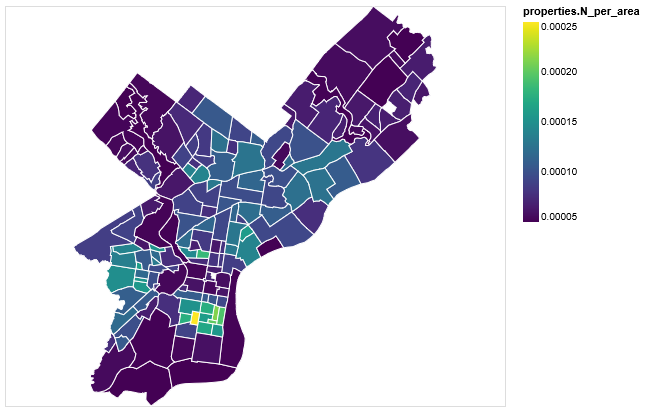

In [35]:
# create an altair data source from a GeoJSON representation
data  = alt.InlineData(values=totals.to_crs(epsg=4326).to_json(),
                       format=alt.DataFormat(property='features',type='json'))

# plot map, where variables are nested within `properties`, 
alt.Chart(data).mark_geoshape(
    stroke='white',
).properties(
    width=500,
    height=400,
    projection={"type":'mercator'},
).encode(
    tooltip=['properties.N_per_area:Q', 'properties.ZillowName:N'],
    color='properties.N_per_area:Q'
)

As can be seen from the chart above, Newbold is the area with more abandoned vehicles

However, I am more interested in identify trends of vehicle abandonment in Philadelphia.Hence, I will use Datashader to generate an hourly time-lapse GIF to show the trends of vehicle abandonment in Philadelphia.

In [36]:
# Load more packages
import zipfile
import os
import urllib
import dask.dataframe as dd
import datashader as ds
import datashader.transfer_functions as tf
from datashader.colors import Greys9, viridis, inferno

C:\Users\Anthony Ayebiahwe\anaconda3\envs\musa-620\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\Anthony Ayebiahwe\anaconda3\envs\musa-620\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [45]:
abvehicle.head()

the_geom        lon  objectid  \
0   0101000020E6100000EC66674D43CF52C036779195A1FB... -75.238483         2   
11  0101000020E6100000DA709A364AC652C008780C6E6FFE... -75.098280        49   
13  0101000020E6100000E4B3869C48CB52C07395B403AAF4... -75.176307       111   
40  0101000020E61000000E96FB2EF6CB52C06D82DA3542FF... -75.186901       198   
42  0101000020E6100000FA43756B80C252C0FE68D53AB303... -75.039088       200   

    service_request_id  status    status_notes       service_name  \
0              8967058  Closed  Issue Resolved  Abandoned Vehicle   
11             8967079  Closed  Issue Resolved  Abandoned Vehicle   
13             8997243  Closed  Issue Resolved  Abandoned Vehicle   
40            10871487  Closed  Issue Resolved  Abandoned Vehicle   
42             8997403  Closed  Issue Resolved  Abandoned Vehicle   

   service_code agency_responsible  \
0       SR-PD01  Police Department   
11      SR-PD01  Police Department   
13      SR-PD01  Police Department   
40      SR-PD01  Police Department   
42      SR-PD01  Police Department   

                                 the_geom_webmercator  requested_datetime  \
0   0101000020110F00001CC20B6635F35FC1CF3B49E90D8B... 2015-01-11 13:45:00   
11  0101000020110F000078BDCA8FF7E35FC12CE22081298E... 2015-01-11 17:45:00   
13  0101000020110F00006B4EB00C73EC5FC1025391455683... 2015-01-30 20:45:00   
40  0101000020110F000023A615E199ED5FC161F08B29138F... 2016-08-04 10:33:00   
42  0101000020110F00005423104588DD5FC140A03EF8FF93... 2015-02-01 12:45:00   

   updated_datetime expected_datetime          address zipcode  \
0    8/12/2015 3:47   2/19/2015 19:00   5915 SUMMER ST     NaN   
11   8/12/2015 3:47   2/19/2015 19:00   3417 MERCER ST     NaN   
13   8/12/2015 3:47   3/12/2015 20:00  1620 CROATAN PL     NaN   
40  6/15/2017 15:15   9/19/2016 20:00   3347 RIDGE AVE     NaN   
42   8/12/2015 3:47   3/12/2015 20:00  7104 MARSDEN ST     NaN   

                                            media_url        lat  \
0   https://d21tc4b3k3r3vo.cloudfront.net/uploads/...  39.965869   
11  https://d21tc4b3k3r3vo.cloudfront.net/uploads/...  39.987776   
13                                                NaN  39.911438   
40                                                NaN  39.994208   
42                                                NaN  40.028907   

      service_notice                                   Coordinates  hours  
0   30 Business Days  POINT (-8375509.594467666 4860983.645094826)     13  
11  30 Business Days  POINT (-8359902.246749274 4864166.017632049)     17  
13  30 Business Days  POINT (-8368588.198260884 4853081.086994888)     20  
40  30 Business Days  POINT (-8369767.516946348 4865100.649166198)     10  
42  30 Business Days  POINT (-8353313.079109985 4870143.878822387)     12

In [46]:
# change coordinates to Web Mercator (EPSG code 3857)
from datashader.utils import lnglat_to_meters as webm
abvehicle.loc[:, "lon"], abvehicle.loc[:, "lat"], = webm(abvehicle["lon"],abvehicle["lat"])

In [47]:
# extract vehicle abandonment in Philadelphia by hour
abvehicle['requested_datetime'] = pd.to_datetime(abvehicle['requested_datetime'])
abvehicle['hours'] = abvehicle.requested_datetime.dt.hour

In [48]:
PHL = x_range, y_range = ((-8380000,-8340000), (4850000,4890000))
plot_width  = int(500)
plot_height = int(plot_width//1.2)

def create_image(abvehicle, x_range, y_range, w=plot_width, h=plot_height, cmap=viridis):
    
    # create the canvas
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    
    # plot positions, coutning number of passengers
    agg = cvs.points(abvehicle, 'lon', 'lat')
    
    # shade
    img = tf.shade(agg, cmap=cmap, how='eq_hist')
    
    # return an PIL image
    return tf.set_background(img, "black").to_pil()

In [49]:
def convert_to_12hour(hr24):
    """
    Convert from 24 hr to 12 hr.
    """
    from datetime import datetime
    d = datetime.strptime(str(hr24), "%H")
    return d.strftime("%I %p")

In [50]:
def plot_by_hour(fig, abvehicle, hour):
    
    # trim to the specific hour
    abvehicle= abvehicle.loc[abvehicle['hours']==hour]
    
    # create the datashaded image
    x_range = PHL[0]
    y_range = PHL[1]
    img = create_image(abvehicle, x_range, y_range)
    
    # plot the image on a matplotlib axes
    plt.clf()
    ax = fig.gca()
    ax.imshow(img, extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
    ax.axis('off')
    
    # add a text label for the hour
    ax.text(0.05, 0.9, convert_to_12hour(hour), color='white', 
            fontsize=40, ha='left', transform=ax.transAxes)
    
   
    # draw the figure and return the image
    fig.canvas.draw()   
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    return image

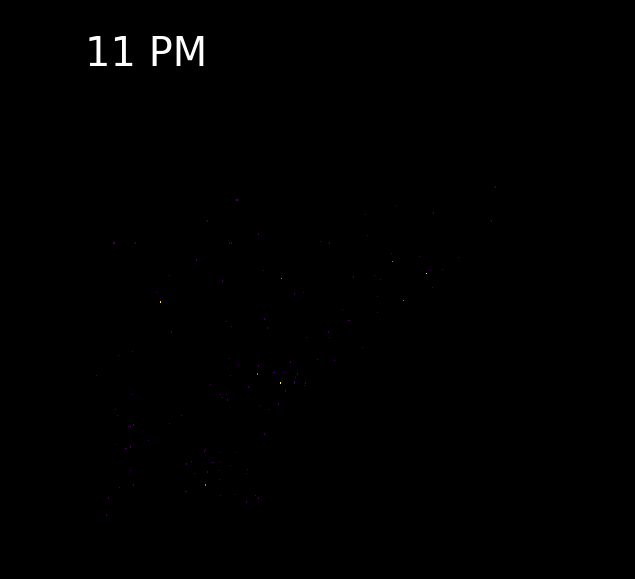

In [51]:
import imageio

# create a figure
fig, ax = plt.subplots(figsize=(10,10), facecolor='black')

# save the GIF
hours = range(24)
imageio.mimsave('C:/Users/Anthony Ayebiahwe/Desktop/vehicle_abandonment.gif', [plot_by_hour(fig, abvehicle, hr) for hr in hours], fps=1);

As can be seen from the GIF, majority of the reports for vehicle abandonment occur from 8am until 5pm in Philadelphia.